#Install Pennylane

In [1]:
!pip install pennylane
!pip install quimb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 32.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 69.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 541.6/541.6 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.8/177.8 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 40.2 MB/s eta 0:00:00


#Code Execution

## Single Qubit

In [2]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [80]:
# Set up the device (1 qubit in this case)
dev = qml.device('lightning.qubit', wires=1, shots=2046)

# Define the quantum circuit ansatz directly as a QNode
@qml.qnode(dev, interface="autograd")
def circuit(params):
    # params[0] is theta_1, params[1] is theta_2
    qml.RY(2*params[0], wires=0)
    qml.RZ(2*params[1], wires=0)
    return qml.expval(qml.PauliX(0))

In [81]:
# Define the cost function (energy expectation)
cost = circuit  # Directly use the QNode as the cost function

# Initialize the optimizers
eta = 0.05  # Learning rate
steps = 15  # Number of iterations

# Initial parameters
theta_initial = np.array([np.pi/ 12, np.pi / 12], requires_grad=True)

In [82]:
# qml.GradientDescentOptimizer for ordinary gradient descent
ordinary_optimizer = qml.GradientDescentOptimizer(stepsize=eta)

# Ordinary Gradient Descent Optimization
params_og = theta_initial.copy()
trajectory_og = [params_og]
energies_og = [cost(params_og)]

for _ in range(steps):
    params_og = ordinary_optimizer.step(cost, params_og)  # Update params with ordinary optimizer

    trajectory_og.append(params_og)
    energies_og.append(cost(params_og))

trajectory_og = np.array(trajectory_og)
energies_og = np.array(energies_og)

In [88]:
# qml.QNGOptimizer for natural gradient descent
natural_optimizer = qml.QNGOptimizer(stepsize=eta, approx='block-diag')

# Natural Gradient Descent Optimization
params_ng = theta_initial.copy()
trajectory_ng = [params_ng]
energies_ng = [cost(params_ng)]

for _ in range(steps):
    metric_tensor_fn = qml.metric_tensor(circuit,approx='block-diag', hybrid=True)
    params_ng = natural_optimizer.step(cost, params_ng, metric_tensor_fn=metric_tensor_fn, recompute_tensor=True)  # Update params with natural optimizer
    trajectory_ng.append(params_ng)
    energies_ng.append(cost(params_ng))

trajectory_ng = np.array(trajectory_ng)
energies_ng = np.array(energies_ng)

In [89]:
# ITE Optimization (Imaginary Time Evolution)
from numpy.linalg import inv
def ite_step(params, eta):
    grad = qml.grad(cost)(params)
    # Fubini-Study metric for ITE
    F = np.array([[1, 0], [0, np.sin(2 * params[0]) ** 2]])
    F_inv = np.linalg.inv(F + np.eye(2) * 1e-4)  # Regularize for stability
    A = F + np.eye(2) * 1e-6  # Approximation for ITE matrix
    return params - eta * np.linalg.inv(A) @ grad

# ITE Optimization Run
params_ite = theta_initial.copy()
trajectory_ite = [params_ite]
energies_ite = [cost(params_ite)]

for _ in range(steps):
    params_ite = ite_step(params_ite, eta)
    trajectory_ite.append(params_ite)
    energies_ite.append(cost(params_ite))

trajectory_ite = np.array(trajectory_ite)
energies_ite = np.array(energies_ite)

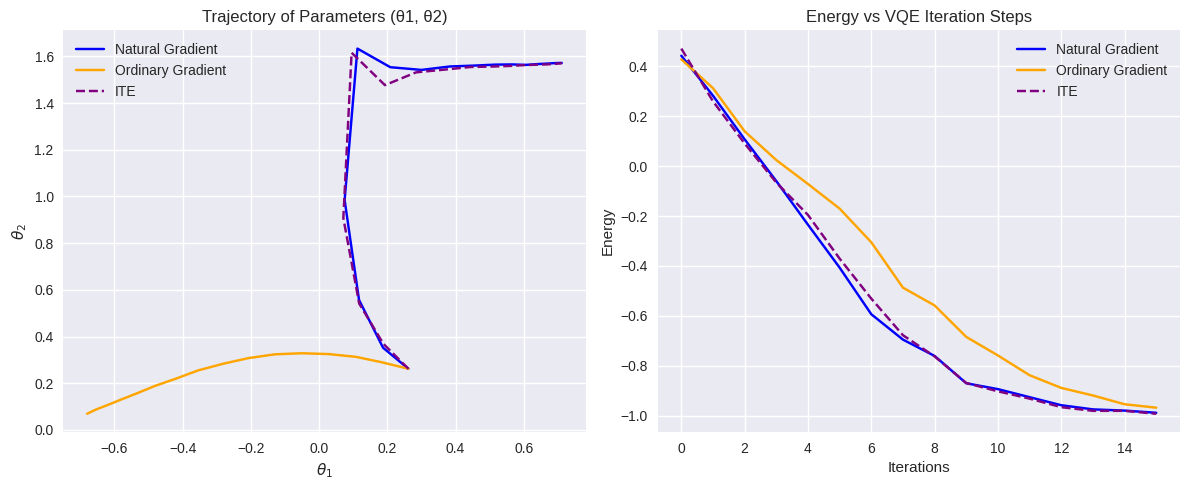

In [90]:
# Plot the results

# Plot Trajectory of parameters (θ1, θ2)
plt.figure(figsize=(12, 5))
plt.style.use("seaborn-v0_8")
plt.subplot(1, 2, 1)
plt.plot(trajectory_ng[:, 0], trajectory_ng[:, 1], label="Natural Gradient", color='blue')
plt.plot(trajectory_og[:, 0], trajectory_og[:, 1], label="Ordinary Gradient",color='orange')
plt.plot(trajectory_ite[:, 0], trajectory_ite[:, 1], label="ITE", color='purple', linestyle='--')
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title("Trajectory of Parameters (θ1, θ2)")
plt.legend()

# Plot Energy vs Iteration Steps
plt.subplot(1, 2, 2)
plt.plot(energies_ng, label="Natural Gradient", color='blue')
plt.plot(energies_og, label="Ordinary Gradient", color='orange')
plt.plot(energies_ite, label="ITE", color='purple', linestyle='--')
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy vs VQE Iteration Steps")
plt.legend()

plt.tight_layout()
plt.show()

## H2

In [97]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

In [98]:
# Define constants for the Hamiltonian
alpha = 0.4
beta = 0.2

# Define the Hamiltonian for H2
H = alpha * (qml.PauliZ(0) @ qml.Identity(1) + qml.Identity(0) @ qml.PauliZ(1)) + beta * qml.PauliX(0) @ qml.PauliX(1)

In [99]:
# Set up the device (1 qubit in this case)
dev = qml.device('lightning.qubit', wires=2, shots=1028)

# Define the quantum circuit ansatz directly as a QNode
@qml.qnode(dev, interface="autograd")
# Define the ansatz for the H2 molecule
def ansatz(params):
    # Apply initial rotations
    qml.RY(2 * params[0], wires=0)
    qml.RY(2 * params[1], wires=1)
    # Apply entangling gate (CNOT)
    qml.CNOT(wires=[0, 1])
    # Apply final rotations
    qml.RY(2 * params[2], wires=0)
    qml.RY(2 * params[3], wires=1)
    return qml.expval(H)# Measure the expectation value of the Hamiltonian

In [100]:
#define ansatz as cost
cost = ansatz

# Initial parameters
theta_initial = np.array([-0.2, -0.2, 0.0, 0.0], requires_grad=True)
eta = 0.05  # Learning rate
steps = 50  # Number of iterations

In [101]:
# qml.GradientDescentOptimizer for ordinary gradient descent
ordinary_optimizer = qml.GradientDescentOptimizer(stepsize=eta)

# Ordinary Gradient Descent Optimization
params_og = theta_initial.copy()
trajectory_og = [params_og]
energies_og = [cost(params_og)]

for _ in range(steps):
    params_og = ordinary_optimizer.step(cost, params_og)  # Update params with ordinary optimizer

    trajectory_og.append(params_og)
    energies_og.append(cost(params_og))

trajectory_og = np.array(trajectory_og)
energies_og = np.array(energies_og)

In [102]:
# qml.QNGOptimizer for natural gradient descent
natural_optimizer = qml.QNGOptimizer(stepsize=eta, approx='block-diag')

# Natural Gradient Descent Optimization
params_ng = theta_initial.copy()
trajectory_ng = [params_ng]
energies_ng = [cost(params_ng)]

for _ in range(steps):
    metric_tensor_fn = qml.metric_tensor(ansatz,approx='block-diag', hybrid=True)
    params_ng = natural_optimizer.step(cost, params_ng, metric_tensor_fn=metric_tensor_fn, recompute_tensor=True)  # Update params with natural optimizer
    trajectory_ng.append(params_ng)
    energies_ng.append(cost(params_ng))

trajectory_ng = np.array(trajectory_ng)
energies_ng = np.array(energies_ng)

In [103]:
# Convert lists to numpy arrays for easy plotting
trajectory_og = np.array(trajectory_og)
trajectory_ng = np.array(trajectory_ng)
energies_og = np.array(energies_og)
energies_ng = np.array(energies_ng)

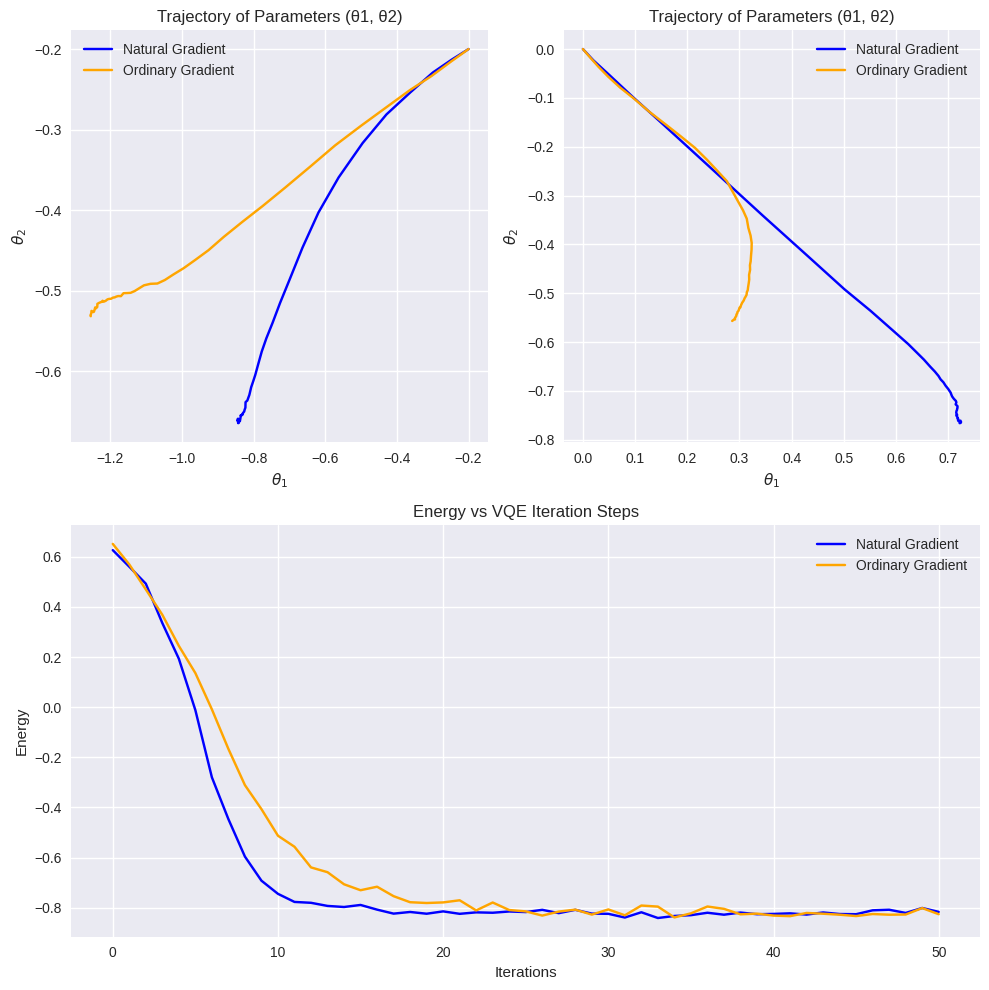

In [107]:
# Plot the results

plt.figure(figsize=(10, 10))
plt.style.use("seaborn-v0_8")

# Plot Trajectory of parameters (θ1, θ2)
plt.subplot(2, 2, 1)
plt.plot(trajectory_ng[:, 0], trajectory_ng[:, 1], label="Natural Gradient", color='blue')
plt.plot(trajectory_og[:, 0], trajectory_og[:, 1], label="Ordinary Gradient",color='orange')
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title("Trajectory of Parameters (θ1, θ2)")
plt.legend()


# Plot Trajectory of parameters (θ1, θ2)
plt.subplot(2, 2, 2)
plt.plot(trajectory_ng[:, 2], trajectory_ng[:, 3], label="Natural Gradient", color='blue')
plt.plot(trajectory_og[:, 2], trajectory_og[:, 3], label="Ordinary Gradient",color='orange')
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.title("Trajectory of Parameters (θ1, θ2)")
plt.legend()


# Plot Energy vs Iteration Steps
plt.subplot(2, 1, 2)
plt.plot(energies_ng, label="Natural Gradient", color='blue')
plt.plot(energies_og, label="Ordinary Gradient", color='orange')
plt.xlabel("Iterations")
plt.ylabel("Energy")
plt.title("Energy vs VQE Iteration Steps")
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Convert lists to numpy arrays for easy plotting
trajectory_og = np.array(trajectory_og)
trajectory_ng = np.array(trajectory_ng)
energies_og = np.array(energies_og)
energies_ng = np.array(energies_ng)

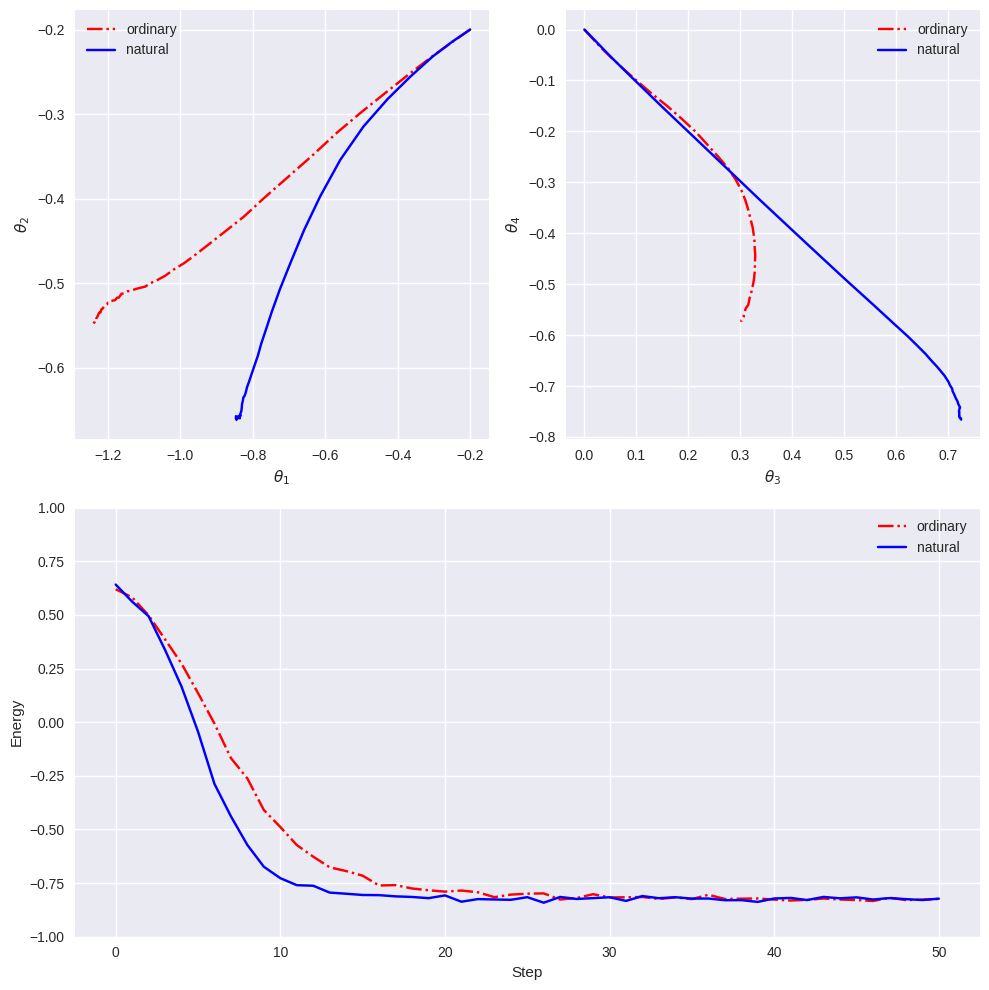

In [25]:
# Plotting
plt.figure(figsize=(10, 10))
plt.style.use("seaborn-v0_8")
# Plot θ1 vs θ2
plt.subplot(2, 2, 1)
plt.plot(trajectory_og[:, 0], trajectory_og[:, 1], 'r-.', label="ordinary")
plt.plot(trajectory_ng[:, 0], trajectory_ng[:, 1], 'b-', label="natural")
plt.xlabel(r"$\theta_1$")
plt.ylabel(r"$\theta_2$")
plt.legend()

# Plot θ3 vs θ4
plt.subplot(2, 2, 2)
plt.plot(trajectory_og[:, 2], trajectory_og[:, 3], 'r-.', label="ordinary")
plt.plot(trajectory_ng[:, 2], trajectory_ng[:, 3], 'b-', label="natural")
plt.xlabel(r"$\theta_3$")
plt.ylabel(r"$\theta_4$")
plt.legend()

# Plot Energy vs Iteration Steps
plt.subplot(2, 1, 2)
plt.ylim(-1, 1)
plt.plot(energies_og, 'r-.', label="ordinary")
plt.plot(energies_ng, 'b-', label="natural")
plt.xlabel("Step")
plt.ylabel("Energy")
plt.legend()

plt.tight_layout()
plt.show()

